In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

Replace the following variables according to your needs:

In [39]:
my_vcf = "copie.sv.vcf"

In [40]:
def getVCFattributes(file):
    attributes = []
    with open(file, "r") as vcf:
        for line in vcf:
            if line.startswith("#CHROM"):
                for column in line.split("\t"):
                    attributes.append(column)
    return attributes

getVCFattributes(my_vcf)

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'QUAL',
 'FILTER',
 'INFO',
 'FORMAT',
 'P15-1.trimed1000',
 'P30-1.trimed1000',
 'P50-1.trimed1000\n']

In [41]:
def reworkVCFtoDataframe(file):
    df = pd.read_csv(file, sep='\t', comment='#', names=getVCFattributes(file), header=0) # convert to pandas dataframe
    new_attributes = ["PRECISION", "SVTYPE", "SVLEN", "END", "SUPPORT", "COVERAGE", "STRAND", "AF", "STDEV_LEN", "STDEV_POS", "SUPPORT_LONG", "AC"]
    df[new_attributes] = df["INFO"].str.split(';', expand=True) # split the INFO column into several ones
    for attribute in new_attributes:
        df[attribute] = df[attribute].str.replace(attribute + '=', '') # remove useless string part after splitting
    df = df.rename(columns={"#CHROM": "CHROM", "P50-1.trimed1000\n": "P50-1.trimed1000"})
    return df[["CHROM", "POS", "SVTYPE", "SVLEN", "P15-1.trimed1000", "P30-1.trimed1000", "P50-1.trimed1000"]]

reworkVCFtoDataframe(my_vcf)

,CHROM,POS,SVTYPE,SVLEN,P15-1.trimed1000,P30-1.trimed1000,P50-1.trimed1000
0,DQ657948.1,1210,INS,12,0/1:60:246:246,./.:.:.:.,./.:.:.:.
1,DQ657948.1,11375,INS,31,0/1:60:317:417,./.:.:.:.,./.:.:.:.
2,DQ657948.1,11384,DEL,-33,0/1:60:363:374,./.:.:.:.,./.:.:.:.
3,DQ657948.1,14453,INS,25,0/1:60:302:360,./.:.:.:.,./.:.:.:.
4,DQ657948.1,16096,DEL,-22,0/1:60:444:254,./.:.:.:.,./.:.:.:.
...,...,...,...,...,...,...,...
125,DQ657948.1,270719,INS,34,0/0:60:305:67,0/1:6:1032:288,./.:.:.:.
126,DQ657948.1,270829,INS,19,0/1:60:221:157,./.:.:.:.,./.:.:.:.
127,DQ657948.1,271616,INS,12,0/1:60:184:182,./.:.:.:.,./.:.:.:.
128,DQ657948.1,272012,DEL,-24,0/1:60:187:176,1/1:60:178:1155,./.:.:.:.


In [44]:
def DataframePerPassage(file, adjacent_pos):
    df = reworkVCFtoDataframe(file)
    for sample in ["P15", "P30", "P50"]:
        DV = sample + "_DV"
        DR = sample + "_DR"
        df[DR] = df[sample + "-1.trimed1000"].str.split(':').str[-2]
        df[DV] = df[sample + "-1.trimed1000"].str.split(':').str[-1] # SUPPORT
        df[DR] = pd.to_numeric(df[DR], errors="coerce").fillna(0).astype(int) # transform into int; if string then changed to nan
        df[DV] = pd.to_numeric(df[DV], errors="coerce").fillna(0).astype(int) # transform into int; if string then changed to nan
        df[sample + "_AF"] = (df[DV])/(df[DV] + df[DR])
        df[sample + "_AF"] = df[sample + "_AF"].fillna(0)
    if adjacent_pos == True:
        df["diff"] = df["POS"].diff()
        df = df[~(df["diff"] < 30)]
    display(df)
    return df.drop(columns=["P15-1.trimed1000", "P30-1.trimed1000", "P50-1.trimed1000"])
    
DataframePerPassage(my_vcf, True).to_csv("t-filtered.tsv", sep="\t", index=False) # save as TSV
DataframePerPassage(my_vcf, True)

,CHROM,POS,SVTYPE,SVLEN,P15-1.trimed1000,P30-1.trimed1000,P50-1.trimed1000,P15_DR,P15_DV,P15_AF,P30_DR,P30_DV,P30_AF,P50_DR,P50_DV,P50_AF,diff
0,DQ657948.1,1210,INS,12,0/1:60:246:246,./.:.:.:.,./.:.:.:.,246,246,0.500000,0,0,0.000000,0,0,0.0,NaN
1,DQ657948.1,11375,INS,31,0/1:60:317:417,./.:.:.:.,./.:.:.:.,317,417,0.568120,0,0,0.000000,0,0,0.0,10165.0
3,DQ657948.1,14453,INS,25,0/1:60:302:360,./.:.:.:.,./.:.:.:.,302,360,0.543807,0,0,0.000000,0,0,0.0,3069.0
4,DQ657948.1,16096,DEL,-22,0/1:60:444:254,./.:.:.:.,./.:.:.:.,444,254,0.363897,0,0,0.000000,0,0,0.0,1643.0
5,DQ657948.1,19040,DEL,-97,./.:.:.:.,0/0:60:2208:83,./.:.:.:.,0,0,0.000000,2208,83,0.036229,0,0,0.0,2944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,DQ657948.1,270645,DEL,-15,0/1:60:211:163,./.:.:.:.,./.:.:.:.,211,163,0.435829,0,0,0.000000,0,0,0.0,5468.0
125,DQ657948.1,270719,INS,34,0/0:60:305:67,0/1:6:1032:288,./.:.:.:.,305,67,0.180108,1032,288,0.218182,0,0,0.0,74.0
126,DQ657948.1,270829,INS,19,0/1:60:221:157,./.:.:.:.,./.:.:.:.,221,157,0.415344,0,0,0.000000,0,0,0.0,110.0
127,DQ657948.1,271616,INS,12,0/1:60:184:182,./.:.:.:.,./.:.:.:.,184,182,0.497268,0,0,0.000000,0,0,0.0,787.0


,CHROM,POS,SVTYPE,SVLEN,P15-1.trimed1000,P30-1.trimed1000,P50-1.trimed1000,P15_DR,P15_DV,P15_AF,P30_DR,P30_DV,P30_AF,P50_DR,P50_DV,P50_AF,diff
0,DQ657948.1,1210,INS,12,0/1:60:246:246,./.:.:.:.,./.:.:.:.,246,246,0.500000,0,0,0.000000,0,0,0.0,NaN
1,DQ657948.1,11375,INS,31,0/1:60:317:417,./.:.:.:.,./.:.:.:.,317,417,0.568120,0,0,0.000000,0,0,0.0,10165.0
3,DQ657948.1,14453,INS,25,0/1:60:302:360,./.:.:.:.,./.:.:.:.,302,360,0.543807,0,0,0.000000,0,0,0.0,3069.0
4,DQ657948.1,16096,DEL,-22,0/1:60:444:254,./.:.:.:.,./.:.:.:.,444,254,0.363897,0,0,0.000000,0,0,0.0,1643.0
5,DQ657948.1,19040,DEL,-97,./.:.:.:.,0/0:60:2208:83,./.:.:.:.,0,0,0.000000,2208,83,0.036229,0,0,0.0,2944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,DQ657948.1,270645,DEL,-15,0/1:60:211:163,./.:.:.:.,./.:.:.:.,211,163,0.435829,0,0,0.000000,0,0,0.0,5468.0
125,DQ657948.1,270719,INS,34,0/0:60:305:67,0/1:6:1032:288,./.:.:.:.,305,67,0.180108,1032,288,0.218182,0,0,0.0,74.0
126,DQ657948.1,270829,INS,19,0/1:60:221:157,./.:.:.:.,./.:.:.:.,221,157,0.415344,0,0,0.000000,0,0,0.0,110.0
127,DQ657948.1,271616,INS,12,0/1:60:184:182,./.:.:.:.,./.:.:.:.,184,182,0.497268,0,0,0.000000,0,0,0.0,787.0


,CHROM,POS,SVTYPE,SVLEN,P15_DR,P15_DV,P15_AF,P30_DR,P30_DV,P30_AF,P50_DR,P50_DV,P50_AF,diff
0,DQ657948.1,1210,INS,12,246,246,0.500000,0,0,0.000000,0,0,0.0,NaN
1,DQ657948.1,11375,INS,31,317,417,0.568120,0,0,0.000000,0,0,0.0,10165.0
3,DQ657948.1,14453,INS,25,302,360,0.543807,0,0,0.000000,0,0,0.0,3069.0
4,DQ657948.1,16096,DEL,-22,444,254,0.363897,0,0,0.000000,0,0,0.0,1643.0
5,DQ657948.1,19040,DEL,-97,0,0,0.000000,2208,83,0.036229,0,0,0.0,2944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,DQ657948.1,270645,DEL,-15,211,163,0.435829,0,0,0.000000,0,0,0.0,5468.0
125,DQ657948.1,270719,INS,34,305,67,0.180108,1032,288,0.218182,0,0,0.0,74.0
126,DQ657948.1,270829,INS,19,221,157,0.415344,0,0,0.000000,0,0,0.0,110.0
127,DQ657948.1,271616,INS,12,184,182,0.497268,0,0,0.000000,0,0,0.0,787.0


After building the dataframe to show the different structural variants fluctuating per passage, we are going to prepare the dataset for the Venn diagram.

To plot this diagram, we are going to create three sets (as lists) that contains the ID of the structural variant.

The sets will be contained in a dictionary to make the retrieval easier.

In [21]:
def makeVennSets(pd_dataframe):
    dict = {"P15" : [],
            "P30" : [],
            "P50" : []
           }
    for key in dict:
        id = 0
        for row in pd_dataframe[key + "_DV"].to_list(): # iterate through the DV list of the dataframe
            if row > 0:
                dict[key].append(id)
            id += 1
    return dict

makeVennSets(DataframePerPassage(my_vcf, True))


,CHROM,POS,SVTYPE,SVLEN,P15-1.trimed1000,P30-1.trimed1000,P50-1.trimed1000,P15_DR,P15_DV,P15_AF,P30_DR,P30_DV,P30_AF,P50_DR,P50_DV,P50_AF,diff
0,DQ657948.1,1210,INS,12,0/1:60:246:246,./.:.:.:.,./.:.:.:.,246,246,0.500000,0,0,0.000000,0,0,0.0,NaN
1,DQ657948.1,11375,INS,31,0/1:60:317:417,./.:.:.:.,./.:.:.:.,317,417,0.568120,0,0,0.000000,0,0,0.0,10165.0
3,DQ657948.1,14453,INS,25,0/1:60:302:360,./.:.:.:.,./.:.:.:.,302,360,0.543807,0,0,0.000000,0,0,0.0,3069.0
4,DQ657948.1,16096,DEL,-22,0/1:60:444:254,./.:.:.:.,./.:.:.:.,444,254,0.363897,0,0,0.000000,0,0,0.0,1643.0
5,DQ657948.1,19040,DEL,-97,./.:.:.:.,0/0:60:2208:83,./.:.:.:.,0,0,0.000000,2208,83,0.036229,0,0,0.0,2944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,DQ657948.1,270645,DEL,-15,0/1:60:211:163,./.:.:.:.,./.:.:.:.,211,163,0.435829,0,0,0.000000,0,0,0.0,5468.0
125,DQ657948.1,270719,INS,34,0/0:60:305:67,0/1:6:1032:288,./.:.:.:.,305,67,0.180108,1032,288,0.218182,0,0,0.0,74.0
126,DQ657948.1,270829,INS,19,0/1:60:221:157,./.:.:.:.,./.:.:.:.,221,157,0.415344,0,0,0.000000,0,0,0.0,110.0
127,DQ657948.1,271616,INS,12,0/1:60:184:182,./.:.:.:.,./.:.:.:.,184,182,0.497268,0,0,0.000000,0,0,0.0,787.0


{'P15': [0,
  1,
  2,
  3,
  5,
  6,
  7,
  9,
  10,
  11,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  28,
  29,
  30,
  32,
  33,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63],
 'P30': [4,
  7,
  10,
  11,
  14,
  15,
  16,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  27,
  29,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  41,
  42,
  44,
  45,
  49,
  51,
  52,
  53,
  54,
  57,
  60,
  63],
 'P50': [8, 12, 13, 14, 16, 18, 19, 20, 32, 42, 43, 50, 52, 53, 55, 57]}

Plot the three sets as a Venn diagram using Matplotlib-venn

,CHROM,POS,SVTYPE,SVLEN,P15-1.trimed1000,P30-1.trimed1000,P50-1.trimed1000,P15_DR,P15_DV,P15_AF,P30_DR,P30_DV,P30_AF,P50_DR,P50_DV,P50_AF,diff
0,DQ657948.1,1210,INS,12,0/1:60:246:246,./.:.:.:.,./.:.:.:.,246,246,0.500000,0,0,0.000000,0,0,0.0,NaN
1,DQ657948.1,11375,INS,31,0/1:60:317:417,./.:.:.:.,./.:.:.:.,317,417,0.568120,0,0,0.000000,0,0,0.0,10165.0
3,DQ657948.1,14453,INS,25,0/1:60:302:360,./.:.:.:.,./.:.:.:.,302,360,0.543807,0,0,0.000000,0,0,0.0,3069.0
4,DQ657948.1,16096,DEL,-22,0/1:60:444:254,./.:.:.:.,./.:.:.:.,444,254,0.363897,0,0,0.000000,0,0,0.0,1643.0
5,DQ657948.1,19040,DEL,-97,./.:.:.:.,0/0:60:2208:83,./.:.:.:.,0,0,0.000000,2208,83,0.036229,0,0,0.0,2944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,DQ657948.1,270645,DEL,-15,0/1:60:211:163,./.:.:.:.,./.:.:.:.,211,163,0.435829,0,0,0.000000,0,0,0.0,5468.0
125,DQ657948.1,270719,INS,34,0/0:60:305:67,0/1:6:1032:288,./.:.:.:.,305,67,0.180108,1032,288,0.218182,0,0,0.0,74.0
126,DQ657948.1,270829,INS,19,0/1:60:221:157,./.:.:.:.,./.:.:.:.,221,157,0.415344,0,0,0.000000,0,0,0.0,110.0
127,DQ657948.1,271616,INS,12,0/1:60:184:182,./.:.:.:.,./.:.:.:.,184,182,0.497268,0,0,0.000000,0,0,0.0,787.0


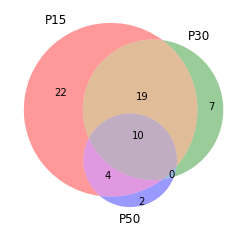

<Figure size 1152x864 with 0 Axes>

In [22]:
sets = makeVennSets(DataframePerPassage(my_vcf, True))
set15 = set(sets["P15"])
set30 = set(sets["P30"])
set50 = set(sets["P50"])

# Create a Venn diagram
venn3([set15, set30, set50], ("P15", "P30", "P50"))
plt.figure(figsize=(8*2, 6*2))
# Display the plot
plt.show()